<a href="https://colab.research.google.com/github/uncertainity/GMM---Sampling-and-EM/blob/main/GMM_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
gmm = tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(probs=[0.3, 0.7]),
      components_distribution=tfd.MultivariateNormalDiag(loc=[[-1., 1],[2.,1.]],scale_diag=[[0.5, 0.5],[0.5, 0.5]]))

In [ ]:
#gmm = tfd.MixtureSameFamily(
#      mixture_distribution=tfd.Categorical(probs=[0.3, 0.7]),
#      components_distribution=tfd.Normal(loc = [-1,1],scale = [0.2,0.8]))

(100, 2)


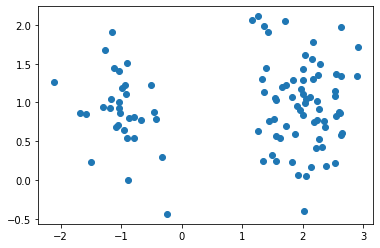

In [3]:
sample = gmm.sample(100)
print(sample.shape)
if sample.ndim == 2:
  plt.scatter(sample[...,0],sample[...,1])

In [4]:
k = sample.numpy()
if k.ndim == 1:
  k = k.reshape(k.shape[0],1)
print(k.shape)

(100, 2)


In [5]:
# Trying to find out the number of clusters bu automating the elbow rule #
def predict_num_clusters(x,d = 4.5):
  wcss = []
  threshold = 0
  n_components = 0
  for i in range(1,7):
    kmeans = KMeans(i)
    kmeans.fit(x)
    wcss_iter = kmeans.inertia_
    if i == 1:
      threshold = wcss_iter/d
    wcss.append(wcss_iter)
    if wcss_iter < threshold:
      n_components = i
      break
  number_clusters = range(1,n_components+1)
  print(wcss)
  plt.plot(number_clusters,wcss)
  plt.title('The Elbow title')
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  return n_components

[241.3046384203112, 44.644326814657646]
No of components: 2


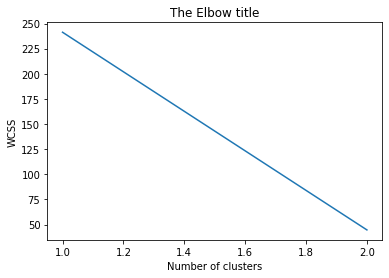

In [6]:
n_components = predict_num_clusters(sample)
print("No of components:",n_components)

In [11]:
## Defining the initial parameters using Kmeans clustering ##
def initialize_params(x):
  n_components = predict_num_clusters(x)
  x = sample.numpy()
  if x.ndim == 1:
    x = x.reshape(x.shape[0],1)
  kmeans = KMeans(n_components)
  f = kmeans.fit_predict(x)
  centres = kmeans.cluster_centers_.tolist()
  variance = []
  probs = []
  for c in range(n_components):
    mask = np.zeros(x.shape[0])
    idx = np.where(f == c)[0]
    x_mask = np.zeros((x.shape[1],idx.shape[0]))
    k = 0
    for id in idx:
      x_mask[:,k] = x[id]
      k += 1
    variance.append(np.cov(x_mask))
    probs.append(idx.shape[0]/x.shape[0])
  initial_params = [probs,centres,variance]
  print("n_components:",n_components)
  print("Initial Parameters:")
  print(initial_params)
  
  return initial_params,n_components


In [12]:
def prob_x_given_z(x,dist):
  return dist.prob(x)

def prob_z(z,dist):
  return dist.prob(z)

In [13]:
## Calculating the resposibility matrix ##
def responsibility_matrix(x,dist_x_given_z_list,dist_z,n_components):
  res_matrix = np.zeros((n_components,x.shape[0]))
  for component in range(n_components):
    dist_x_given_z = dist_x_given_z_list[component]
    n = prob_x_given_z(x.numpy(),dist_x_given_z)*prob_z(component,dist_z).numpy()
    res_matrix[component] = n.numpy()
  d = np.sum(res_matrix,axis = 0)
  res_matrix = res_matrix/d
  return res_matrix

In [14]:
## Defining the initial distributions using cluster mean and variance ##
def initialize_dist(x,params,n_components):
  prob_ = params[0]
  mu_= params[1]
  covariance_matrix_ = params[2]
  dist_x_given_z_list = []
  dist_z = tfd.Categorical(probs = prob_)
  for component in range(n_components):
    if x.ndim == 1:
      dist = tfd.Normal(loc = mu_[component],scale = covariance_matrix_[component])
    else:
      dist = tfd.MultivariateNormalTriL(loc = mu_[component],scale_tril = tf.linalg.cholesky(covariance_matrix_[component]))
    dist_x_given_z_list.append(dist)
  res_matrix = responsibility_matrix(x,dist_x_given_z_list,dist_z,n_components)
  return dist_x_given_z_list,dist_z,res_matrix

[241.3046384203112, 44.644326814657646]
n_components: 2
Initial Parameters:
[[0.68, 0.32], [[2.010395050048828, 0.9791465997695923], [-0.9946774244308472, 0.8940652012825012]], [array([[ 0.19275285, -0.02057903],
       [-0.02057903,  0.30013049]]), array([[ 0.15133659, -0.06479264],
       [-0.06479264,  0.22353899]])]]


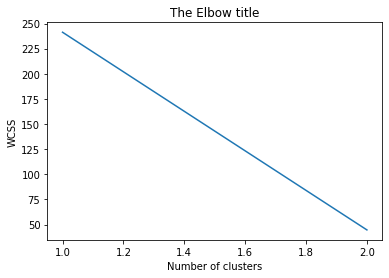

In [15]:
initial_params,n_components = initialize_params(sample)

In [16]:
# Initial Mean #
initial_params[1]

[[2.010395050048828, 0.9791465997695923],
 [-0.9946774244308472, 0.8940652012825012]]

In [17]:
# Initial Variance #
initial_params[2]

[array([[ 0.19275285, -0.02057903],
        [-0.02057903,  0.30013049]]), array([[ 0.15133659, -0.06479264],
        [-0.06479264,  0.22353899]])]

In [18]:
def update_params(x,res_matrix,n_components):
  x_t = x.numpy().transpose()
  if x_t.ndim == 1:
    x_t = x_t.reshape(1,x_t.shape[0])
  d = np.sum(res_matrix,axis = 1)
  prob_ = list(d/np.sum(d))
  mu_ = []
  covariance_matrix_ = []
  for component in range(n_components):
    m = np.sum(x_t*res_matrix[component],axis = 1)/d[component]
    mu_.append(list(m))
    m = m.reshape(x_t.shape[0],1)
    n = ((x_t - m)*res_matrix[component])@(x_t - m).transpose()
    covariance_matrix_.append(n/d[component])
  new_params = [prob_,mu_,covariance_matrix_]
  return new_params

In [19]:
def expectation_maximization(sample,epochs = 200):
  initial_params,n_components = initialize_params(sample)
  dist_x_given_z_list,dist_z,res_matrix = initialize_dist(sample,initial_params,n_components)
  for i in range(50):
    new_params = update_params(sample,res_matrix,n_components)
    dist_x_given_z_list,dist_z,res_matrix = initialize_dist(sample,new_params,n_components)
  return dist_x_given_z_list,dist_z
  #print(dist_z.probs)


[241.3046384203112, 44.644326814657646]
n_components: 2
Initial Parameters:
[[0.68, 0.32], [[2.010395050048828, 0.9791465997695923], [-0.9946774244308472, 0.8940652012825012]], [array([[ 0.19275285, -0.02057903],
       [-0.02057903,  0.30013049]]), array([[ 0.15133659, -0.06479264],
       [-0.06479264,  0.22353899]])]]


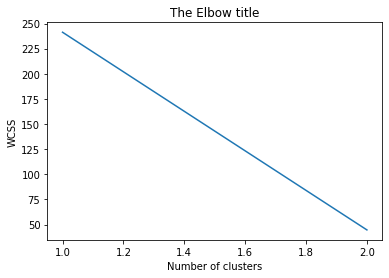

In [20]:
dist_x_given_z_list,dist_z = expectation_maximization(sample)

In [21]:
print(dist_z.probs)

tf.Tensor([0.68000005 0.31999995], shape=(2,), dtype=float64)


In [23]:
for i in range (len(dist_x_given_z_list)):
  print("Cluster ",i,"parameters:")
  print("Mean:",dist_x_given_z_list[i].parameters["loc"])
  l = dist_x_given_z_list[i].parameters["scale_tril"]
  print("Variance:",l@tf.transpose(l))

Cluster  0 parameters:
Mean: ListWrapper([2.0103949204677094, 0.9791465408242753])
Variance: tf.Tensor(
[[ 0.18991861 -0.02027627]
 [-0.02027627  0.29571686]], shape=(2, 2), dtype=float64)
Cluster  1 parameters:
Mean: ListWrapper([-0.9946772743749605, 0.8940653143448865])
Variance: tf.Tensor(
[[ 0.14660729 -0.0627678 ]
 [-0.0627678   0.21655329]], shape=(2, 2), dtype=float64)
